In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

In [4]:
update_indexes()

Updated 2020-04-20, max actual date:     2020-04-17


In [5]:
update_stocks()

Updated 2020-04-20, max actual date:     2020-04-20


In [6]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 1967 and indexes: 23


In [7]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

## Single plot

### Plot code

In [164]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [169]:
[a for a in all_stocks if 'PEKAO' in a]

['PEKAO.mst']

In [173]:
papier = 'PKOBP'

In [174]:
#plot_paper(papier,'2008-07-15','2008-11-15')

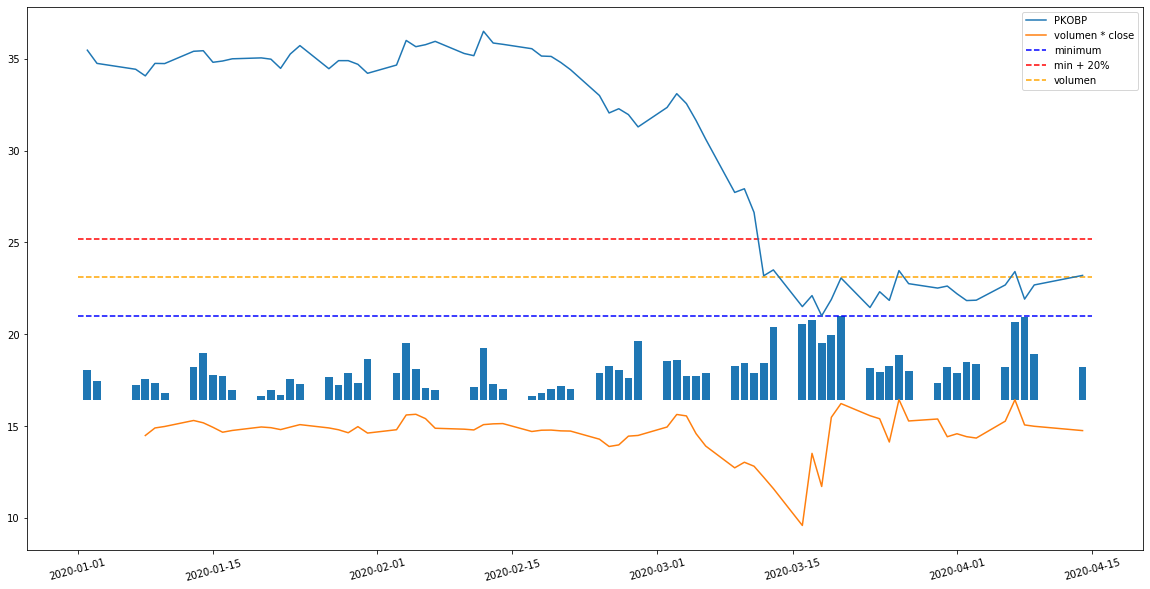

In [175]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [145]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [146]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: PLAY, currently at 33.8, with potential 12.43% to top
Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 33.8, at 2020-04-09 00:00:00
Stats after Max: [33.8]


## Skaner

In [8]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [9]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1967/1967 [00:11<00:00, 168.50it/s]


In [10]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [11]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        (skaner_df.growth_current > 0)
                              ,:].sort_values('drop_current', ascending=True)

In [12]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('RCL' in x) else True).values,]

In [13]:
skaner_df_see.shape

(486, 14)

## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

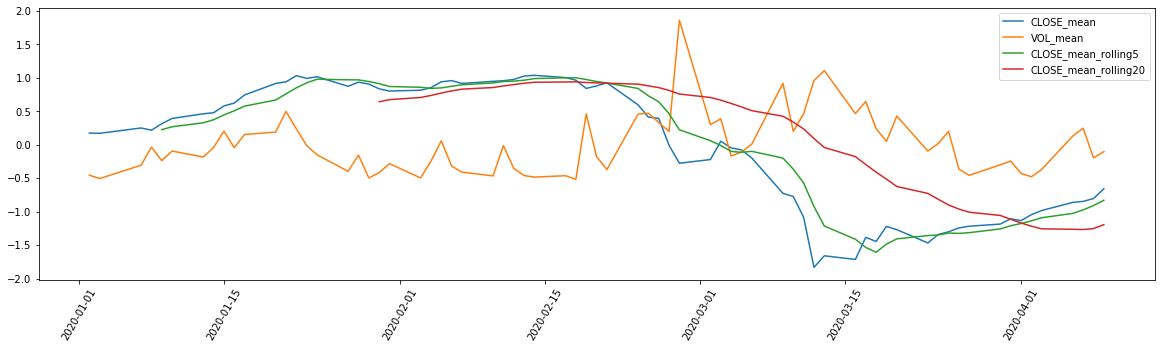

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [14]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5,10,20,30,60]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
    df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
    df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
    return df

def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    return df

In [15]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [16]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

In [17]:
%%time

full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 99%|█████████▉| 481/486 [02:19<00:01,  3.44it/s]

CPU times: user 2min 5s, sys: 378 ms, total: 2min 5s
Wall time: 2min 19s


In [18]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|█████████▉| 483/485 [00:10<00:00, 46.32it/s]


In [19]:
df_merged = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_merged = pd.concat([df_merged, df])
    pbar.update(1)
pbar.close()

100%|██████████| 48/48 [01:14<00:00,  1.56s/it]


In [20]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

58

In [21]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:00<00:00, 34.84it/s]


In [22]:
df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [23]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

train_cols = train_cols + list(df_indexes_merged.columns)

#train_cols = ['all_lower_cat', 'all_higher_cat'] + train_cols

In [24]:
#train_cols = train_cols_limited

df = df_merged.copy()
#df = df.loc[df.index > '2007-01-01',:]

In [25]:
cut_date = '2020-03-13'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [38]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')
    return model

In [39]:
model = get_model()

In [40]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          eval_set=[(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=500, use_best_model=True)

0:	learn: 0.6756926	test: 0.6485393	best: 0.6485393 (0)	total: 25.3ms	remaining: 4m 13s
1:	learn: 0.6849380	test: 0.6627303	best: 0.6627303 (1)	total: 49.9ms	remaining: 4m 9s
2:	learn: 0.6903065	test: 0.6679147	best: 0.6679147 (2)	total: 74.6ms	remaining: 4m 8s
3:	learn: 0.6910566	test: 0.6679158	best: 0.6679158 (3)	total: 99.4ms	remaining: 4m 8s
4:	learn: 0.6935365	test: 0.6763359	best: 0.6763359 (4)	total: 123ms	remaining: 4m 6s
5:	learn: 0.6961554	test: 0.6781847	best: 0.6781847 (5)	total: 148ms	remaining: 4m 6s
6:	learn: 0.6971390	test: 0.6778603	best: 0.6781847 (5)	total: 172ms	remaining: 4m 5s
7:	learn: 0.6982369	test: 0.6788698	best: 0.6788698 (7)	total: 196ms	remaining: 4m 4s
8:	learn: 0.6988315	test: 0.6795024	best: 0.6795024 (8)	total: 220ms	remaining: 4m 4s
9:	learn: 0.6990197	test: 0.6801754	best: 0.6801754 (9)	total: 246ms	remaining: 4m 5s
10:	learn: 0.6997312	test: 0.6806093	best: 0.6806093 (10)	total: 275ms	remaining: 4m 9s
11:	learn: 0.7001324	test: 0.6815229	best: 0.68

94:	learn: 0.7127923	test: 0.6973023	best: 0.6973354 (88)	total: 2.16s	remaining: 3m 45s
95:	learn: 0.7128616	test: 0.6973726	best: 0.6973726 (95)	total: 2.18s	remaining: 3m 45s
96:	learn: 0.7128946	test: 0.6973944	best: 0.6973944 (96)	total: 2.2s	remaining: 3m 44s
97:	learn: 0.7129581	test: 0.6976985	best: 0.6976985 (97)	total: 2.22s	remaining: 3m 44s
98:	learn: 0.7130228	test: 0.6977893	best: 0.6977893 (98)	total: 2.24s	remaining: 3m 44s
99:	learn: 0.7130829	test: 0.6976177	best: 0.6977893 (98)	total: 2.26s	remaining: 3m 44s
100:	learn: 0.7131214	test: 0.6978899	best: 0.6978899 (100)	total: 2.28s	remaining: 3m 43s
101:	learn: 0.7131740	test: 0.6979020	best: 0.6979020 (101)	total: 2.3s	remaining: 3m 43s
102:	learn: 0.7132400	test: 0.6979894	best: 0.6979894 (102)	total: 2.32s	remaining: 3m 43s
103:	learn: 0.7133109	test: 0.6980884	best: 0.6980884 (103)	total: 2.35s	remaining: 3m 43s
104:	learn: 0.7133486	test: 0.6981418	best: 0.6981418 (104)	total: 2.37s	remaining: 3m 43s
105:	learn: 0

194:	learn: 0.7165005	test: 0.7006448	best: 0.7006657 (190)	total: 4.25s	remaining: 3m 33s
195:	learn: 0.7165281	test: 0.7006481	best: 0.7006657 (190)	total: 4.27s	remaining: 3m 33s
196:	learn: 0.7165540	test: 0.7006745	best: 0.7006745 (196)	total: 4.29s	remaining: 3m 33s
197:	learn: 0.7165731	test: 0.7006767	best: 0.7006767 (197)	total: 4.31s	remaining: 3m 33s
198:	learn: 0.7165893	test: 0.7007061	best: 0.7007061 (198)	total: 4.34s	remaining: 3m 33s
199:	learn: 0.7166032	test: 0.7008823	best: 0.7008823 (199)	total: 4.35s	remaining: 3m 33s
200:	learn: 0.7166275	test: 0.7009134	best: 0.7009134 (200)	total: 4.38s	remaining: 3m 33s
201:	learn: 0.7166455	test: 0.7009052	best: 0.7009134 (200)	total: 4.4s	remaining: 3m 33s
202:	learn: 0.7166664	test: 0.7009190	best: 0.7009190 (202)	total: 4.42s	remaining: 3m 33s
203:	learn: 0.7166885	test: 0.7008674	best: 0.7009190 (202)	total: 4.44s	remaining: 3m 33s
204:	learn: 0.7167082	test: 0.7009173	best: 0.7009190 (202)	total: 4.46s	remaining: 3m 33s


293:	learn: 0.7184860	test: 0.7021350	best: 0.7021350 (293)	total: 6.32s	remaining: 3m 28s
294:	learn: 0.7185026	test: 0.7021289	best: 0.7021350 (293)	total: 6.34s	remaining: 3m 28s
295:	learn: 0.7185159	test: 0.7021367	best: 0.7021367 (295)	total: 6.36s	remaining: 3m 28s
296:	learn: 0.7185311	test: 0.7021242	best: 0.7021367 (295)	total: 6.38s	remaining: 3m 28s
297:	learn: 0.7185491	test: 0.7021578	best: 0.7021578 (297)	total: 6.41s	remaining: 3m 28s
298:	learn: 0.7185696	test: 0.7021942	best: 0.7021942 (298)	total: 6.43s	remaining: 3m 28s
299:	learn: 0.7185911	test: 0.7022052	best: 0.7022052 (299)	total: 6.45s	remaining: 3m 28s
300:	learn: 0.7186092	test: 0.7021973	best: 0.7022052 (299)	total: 6.47s	remaining: 3m 28s
301:	learn: 0.7186294	test: 0.7022147	best: 0.7022147 (301)	total: 6.49s	remaining: 3m 28s
302:	learn: 0.7186436	test: 0.7022699	best: 0.7022699 (302)	total: 6.51s	remaining: 3m 28s
303:	learn: 0.7186577	test: 0.7023927	best: 0.7023927 (303)	total: 6.53s	remaining: 3m 28s

391:	learn: 0.7198774	test: 0.7032030	best: 0.7032030 (391)	total: 8.43s	remaining: 3m 26s
392:	learn: 0.7198891	test: 0.7031870	best: 0.7032030 (391)	total: 8.45s	remaining: 3m 26s
393:	learn: 0.7198979	test: 0.7031754	best: 0.7032030 (391)	total: 8.47s	remaining: 3m 26s
394:	learn: 0.7199116	test: 0.7031863	best: 0.7032030 (391)	total: 8.49s	remaining: 3m 26s
395:	learn: 0.7199175	test: 0.7032943	best: 0.7032943 (395)	total: 8.51s	remaining: 3m 26s
396:	learn: 0.7199275	test: 0.7032624	best: 0.7032943 (395)	total: 8.54s	remaining: 3m 26s
397:	learn: 0.7199377	test: 0.7032700	best: 0.7032943 (395)	total: 8.56s	remaining: 3m 26s
398:	learn: 0.7199521	test: 0.7032841	best: 0.7032943 (395)	total: 8.58s	remaining: 3m 26s
399:	learn: 0.7199687	test: 0.7032905	best: 0.7032943 (395)	total: 8.6s	remaining: 3m 26s
400:	learn: 0.7199807	test: 0.7032890	best: 0.7032943 (395)	total: 8.62s	remaining: 3m 26s
401:	learn: 0.7199915	test: 0.7033139	best: 0.7033139 (401)	total: 8.64s	remaining: 3m 26s


490:	learn: 0.7209076	test: 0.7044460	best: 0.7045877 (484)	total: 10.5s	remaining: 3m 23s
491:	learn: 0.7209148	test: 0.7044632	best: 0.7045877 (484)	total: 10.5s	remaining: 3m 23s
492:	learn: 0.7209207	test: 0.7044601	best: 0.7045877 (484)	total: 10.6s	remaining: 3m 23s
493:	learn: 0.7209273	test: 0.7044779	best: 0.7045877 (484)	total: 10.6s	remaining: 3m 23s
494:	learn: 0.7209319	test: 0.7044914	best: 0.7045877 (484)	total: 10.6s	remaining: 3m 23s
495:	learn: 0.7209463	test: 0.7044775	best: 0.7045877 (484)	total: 10.6s	remaining: 3m 23s
496:	learn: 0.7209590	test: 0.7044816	best: 0.7045877 (484)	total: 10.6s	remaining: 3m 23s
497:	learn: 0.7209727	test: 0.7044565	best: 0.7045877 (484)	total: 10.7s	remaining: 3m 23s
498:	learn: 0.7209826	test: 0.7044727	best: 0.7045877 (484)	total: 10.7s	remaining: 3m 23s
499:	learn: 0.7209880	test: 0.7045011	best: 0.7045877 (484)	total: 10.7s	remaining: 3m 23s
500:	learn: 0.7209996	test: 0.7044999	best: 0.7045877 (484)	total: 10.7s	remaining: 3m 23s

583:	learn: 0.7216901	test: 0.7051911	best: 0.7052035 (582)	total: 12.6s	remaining: 3m 23s
584:	learn: 0.7216986	test: 0.7052122	best: 0.7052122 (584)	total: 12.7s	remaining: 3m 23s
585:	learn: 0.7217078	test: 0.7052471	best: 0.7052471 (585)	total: 12.7s	remaining: 3m 23s
586:	learn: 0.7217127	test: 0.7052501	best: 0.7052501 (586)	total: 12.7s	remaining: 3m 23s
587:	learn: 0.7217234	test: 0.7052461	best: 0.7052501 (586)	total: 12.7s	remaining: 3m 23s
588:	learn: 0.7217278	test: 0.7052415	best: 0.7052501 (586)	total: 12.7s	remaining: 3m 23s
589:	learn: 0.7217326	test: 0.7052165	best: 0.7052501 (586)	total: 12.8s	remaining: 3m 23s
590:	learn: 0.7217401	test: 0.7052088	best: 0.7052501 (586)	total: 12.8s	remaining: 3m 23s
591:	learn: 0.7217521	test: 0.7051560	best: 0.7052501 (586)	total: 12.8s	remaining: 3m 23s
592:	learn: 0.7217595	test: 0.7051548	best: 0.7052501 (586)	total: 12.8s	remaining: 3m 23s
593:	learn: 0.7217686	test: 0.7051548	best: 0.7052501 (586)	total: 12.8s	remaining: 3m 23s

683:	learn: 0.7223963	test: 0.7055487	best: 0.7056425 (645)	total: 14.8s	remaining: 3m 20s
684:	learn: 0.7224014	test: 0.7055320	best: 0.7056425 (645)	total: 14.8s	remaining: 3m 20s
685:	learn: 0.7224113	test: 0.7055314	best: 0.7056425 (645)	total: 14.8s	remaining: 3m 20s
686:	learn: 0.7224178	test: 0.7055700	best: 0.7056425 (645)	total: 14.8s	remaining: 3m 20s
687:	learn: 0.7224259	test: 0.7054423	best: 0.7056425 (645)	total: 14.8s	remaining: 3m 20s
688:	learn: 0.7224302	test: 0.7054850	best: 0.7056425 (645)	total: 14.9s	remaining: 3m 20s
689:	learn: 0.7224430	test: 0.7055032	best: 0.7056425 (645)	total: 14.9s	remaining: 3m 20s
690:	learn: 0.7224489	test: 0.7055119	best: 0.7056425 (645)	total: 14.9s	remaining: 3m 20s
691:	learn: 0.7224572	test: 0.7055590	best: 0.7056425 (645)	total: 14.9s	remaining: 3m 20s
692:	learn: 0.7224606	test: 0.7055393	best: 0.7056425 (645)	total: 14.9s	remaining: 3m 20s
693:	learn: 0.7224671	test: 0.7055327	best: 0.7056425 (645)	total: 15s	remaining: 3m 20s
6

780:	learn: 0.7229429	test: 0.7060018	best: 0.7060232 (776)	total: 16.9s	remaining: 3m 19s
781:	learn: 0.7229489	test: 0.7060124	best: 0.7060232 (776)	total: 16.9s	remaining: 3m 19s
782:	learn: 0.7229533	test: 0.7060233	best: 0.7060233 (782)	total: 16.9s	remaining: 3m 19s
783:	learn: 0.7229586	test: 0.7060300	best: 0.7060300 (783)	total: 16.9s	remaining: 3m 19s
784:	learn: 0.7229634	test: 0.7060302	best: 0.7060302 (784)	total: 17s	remaining: 3m 19s
785:	learn: 0.7229694	test: 0.7060499	best: 0.7060499 (785)	total: 17s	remaining: 3m 19s
786:	learn: 0.7229739	test: 0.7060720	best: 0.7060720 (786)	total: 17s	remaining: 3m 18s
787:	learn: 0.7229784	test: 0.7060817	best: 0.7060817 (787)	total: 17s	remaining: 3m 18s
788:	learn: 0.7229833	test: 0.7060649	best: 0.7060817 (787)	total: 17s	remaining: 3m 18s
789:	learn: 0.7229861	test: 0.7060520	best: 0.7060817 (787)	total: 17.1s	remaining: 3m 18s
790:	learn: 0.7229913	test: 0.7060473	best: 0.7060817 (787)	total: 17.1s	remaining: 3m 18s
791:	lear

878:	learn: 0.7234168	test: 0.7063695	best: 0.7063707 (876)	total: 19s	remaining: 3m 16s
879:	learn: 0.7234213	test: 0.7063623	best: 0.7063707 (876)	total: 19s	remaining: 3m 16s
880:	learn: 0.7234249	test: 0.7063457	best: 0.7063707 (876)	total: 19s	remaining: 3m 16s
881:	learn: 0.7234298	test: 0.7063425	best: 0.7063707 (876)	total: 19s	remaining: 3m 16s
882:	learn: 0.7234333	test: 0.7063389	best: 0.7063707 (876)	total: 19.1s	remaining: 3m 16s
883:	learn: 0.7234384	test: 0.7063466	best: 0.7063707 (876)	total: 19.1s	remaining: 3m 16s
884:	learn: 0.7234474	test: 0.7063465	best: 0.7063707 (876)	total: 19.1s	remaining: 3m 16s
885:	learn: 0.7234506	test: 0.7063609	best: 0.7063707 (876)	total: 19.1s	remaining: 3m 16s
886:	learn: 0.7234533	test: 0.7063920	best: 0.7063920 (886)	total: 19.2s	remaining: 3m 16s
887:	learn: 0.7234578	test: 0.7063941	best: 0.7063941 (887)	total: 19.2s	remaining: 3m 16s
888:	learn: 0.7234621	test: 0.7064016	best: 0.7064016 (888)	total: 19.2s	remaining: 3m 16s
889:	le

975:	learn: 0.7238503	test: 0.7065369	best: 0.7065420 (974)	total: 21.1s	remaining: 3m 14s
976:	learn: 0.7238542	test: 0.7065374	best: 0.7065420 (974)	total: 21.1s	remaining: 3m 14s
977:	learn: 0.7238567	test: 0.7065340	best: 0.7065420 (974)	total: 21.1s	remaining: 3m 14s
978:	learn: 0.7238654	test: 0.7065687	best: 0.7065687 (978)	total: 21.2s	remaining: 3m 14s
979:	learn: 0.7238697	test: 0.7065928	best: 0.7065928 (979)	total: 21.2s	remaining: 3m 14s
980:	learn: 0.7238728	test: 0.7065940	best: 0.7065940 (980)	total: 21.2s	remaining: 3m 14s
981:	learn: 0.7238758	test: 0.7065766	best: 0.7065940 (980)	total: 21.2s	remaining: 3m 14s
982:	learn: 0.7238804	test: 0.7065935	best: 0.7065940 (980)	total: 21.2s	remaining: 3m 14s
983:	learn: 0.7238835	test: 0.7065951	best: 0.7065951 (983)	total: 21.3s	remaining: 3m 14s
984:	learn: 0.7238879	test: 0.7065869	best: 0.7065951 (983)	total: 21.3s	remaining: 3m 14s
985:	learn: 0.7238901	test: 0.7065652	best: 0.7065951 (983)	total: 21.3s	remaining: 3m 14s

1064:	learn: 0.7241933	test: 0.7067724	best: 0.7067806 (1061)	total: 23s	remaining: 3m 12s
1065:	learn: 0.7241960	test: 0.7067706	best: 0.7067806 (1061)	total: 23s	remaining: 3m 12s
1066:	learn: 0.7241994	test: 0.7067746	best: 0.7067806 (1061)	total: 23s	remaining: 3m 12s
1067:	learn: 0.7242026	test: 0.7067567	best: 0.7067806 (1061)	total: 23s	remaining: 3m 12s
1068:	learn: 0.7242050	test: 0.7067523	best: 0.7067806 (1061)	total: 23.1s	remaining: 3m 12s
1069:	learn: 0.7242077	test: 0.7067494	best: 0.7067806 (1061)	total: 23.1s	remaining: 3m 12s
1070:	learn: 0.7242119	test: 0.7067887	best: 0.7067887 (1070)	total: 23.1s	remaining: 3m 12s
1071:	learn: 0.7242154	test: 0.7067733	best: 0.7067887 (1070)	total: 23.1s	remaining: 3m 12s
1072:	learn: 0.7242186	test: 0.7067636	best: 0.7067887 (1070)	total: 23.2s	remaining: 3m 12s
1073:	learn: 0.7242216	test: 0.7067547	best: 0.7067887 (1070)	total: 23.2s	remaining: 3m 12s
1074:	learn: 0.7242248	test: 0.7067587	best: 0.7067887 (1070)	total: 23.2s	rem

1159:	learn: 0.7245468	test: 0.7069014	best: 0.7069760 (1139)	total: 25.1s	remaining: 3m 10s
1160:	learn: 0.7245493	test: 0.7069238	best: 0.7069760 (1139)	total: 25.1s	remaining: 3m 10s
1161:	learn: 0.7245528	test: 0.7070068	best: 0.7070068 (1161)	total: 25.1s	remaining: 3m 10s
1162:	learn: 0.7245561	test: 0.7070132	best: 0.7070132 (1162)	total: 25.1s	remaining: 3m 10s
1163:	learn: 0.7245606	test: 0.7070585	best: 0.7070585 (1163)	total: 25.1s	remaining: 3m 10s
1164:	learn: 0.7245641	test: 0.7070600	best: 0.7070600 (1164)	total: 25.2s	remaining: 3m 10s
1165:	learn: 0.7245671	test: 0.7070709	best: 0.7070709 (1165)	total: 25.2s	remaining: 3m 10s
1166:	learn: 0.7245732	test: 0.7070844	best: 0.7070844 (1166)	total: 25.2s	remaining: 3m 10s
1167:	learn: 0.7245754	test: 0.7070859	best: 0.7070859 (1167)	total: 25.2s	remaining: 3m 10s
1168:	learn: 0.7245783	test: 0.7070836	best: 0.7070859 (1167)	total: 25.2s	remaining: 3m 10s
1169:	learn: 0.7245804	test: 0.7071127	best: 0.7071127 (1169)	total: 2

1249:	learn: 0.7248612	test: 0.7072621	best: 0.7074695 (1233)	total: 26.9s	remaining: 3m 8s
1250:	learn: 0.7248647	test: 0.7072645	best: 0.7074695 (1233)	total: 27s	remaining: 3m 8s
1251:	learn: 0.7248701	test: 0.7072715	best: 0.7074695 (1233)	total: 27s	remaining: 3m 8s
1252:	learn: 0.7248740	test: 0.7072139	best: 0.7074695 (1233)	total: 27s	remaining: 3m 8s
1253:	learn: 0.7248774	test: 0.7072065	best: 0.7074695 (1233)	total: 27s	remaining: 3m 8s
1254:	learn: 0.7248815	test: 0.7072045	best: 0.7074695 (1233)	total: 27s	remaining: 3m 8s
1255:	learn: 0.7248872	test: 0.7072070	best: 0.7074695 (1233)	total: 27.1s	remaining: 3m 8s
1256:	learn: 0.7248895	test: 0.7072133	best: 0.7074695 (1233)	total: 27.1s	remaining: 3m 8s
1257:	learn: 0.7248909	test: 0.7072122	best: 0.7074695 (1233)	total: 27.1s	remaining: 3m 8s
1258:	learn: 0.7248937	test: 0.7072148	best: 0.7074695 (1233)	total: 27.1s	remaining: 3m 8s
1259:	learn: 0.7248964	test: 0.7072222	best: 0.7074695 (1233)	total: 27.1s	remaining: 3m 8

1345:	learn: 0.7251913	test: 0.7073420	best: 0.7074695 (1233)	total: 29.1s	remaining: 3m 6s
1346:	learn: 0.7251948	test: 0.7073556	best: 0.7074695 (1233)	total: 29.1s	remaining: 3m 6s
1347:	learn: 0.7252004	test: 0.7072978	best: 0.7074695 (1233)	total: 29.1s	remaining: 3m 6s
1348:	learn: 0.7252031	test: 0.7072954	best: 0.7074695 (1233)	total: 29.1s	remaining: 3m 6s
1349:	learn: 0.7252044	test: 0.7072831	best: 0.7074695 (1233)	total: 29.1s	remaining: 3m 6s
1350:	learn: 0.7252050	test: 0.7072919	best: 0.7074695 (1233)	total: 29.2s	remaining: 3m 6s
1351:	learn: 0.7252055	test: 0.7072965	best: 0.7074695 (1233)	total: 29.2s	remaining: 3m 6s
1352:	learn: 0.7252080	test: 0.7073051	best: 0.7074695 (1233)	total: 29.2s	remaining: 3m 6s
1353:	learn: 0.7252130	test: 0.7072927	best: 0.7074695 (1233)	total: 29.2s	remaining: 3m 6s
1354:	learn: 0.7252154	test: 0.7073051	best: 0.7074695 (1233)	total: 29.3s	remaining: 3m 6s
1355:	learn: 0.7252181	test: 0.7072996	best: 0.7074695 (1233)	total: 29.3s	remai

1441:	learn: 0.7254567	test: 0.7074902	best: 0.7075897 (1410)	total: 31.2s	remaining: 3m 4s
1442:	learn: 0.7254578	test: 0.7075040	best: 0.7075897 (1410)	total: 31.2s	remaining: 3m 4s
1443:	learn: 0.7254605	test: 0.7074569	best: 0.7075897 (1410)	total: 31.2s	remaining: 3m 4s
1444:	learn: 0.7254645	test: 0.7074583	best: 0.7075897 (1410)	total: 31.2s	remaining: 3m 4s
1445:	learn: 0.7254691	test: 0.7074566	best: 0.7075897 (1410)	total: 31.3s	remaining: 3m 4s
1446:	learn: 0.7254704	test: 0.7074574	best: 0.7075897 (1410)	total: 31.3s	remaining: 3m 4s
1447:	learn: 0.7254720	test: 0.7074545	best: 0.7075897 (1410)	total: 31.3s	remaining: 3m 4s
1448:	learn: 0.7254777	test: 0.7074713	best: 0.7075897 (1410)	total: 31.3s	remaining: 3m 4s
1449:	learn: 0.7254789	test: 0.7074686	best: 0.7075897 (1410)	total: 31.4s	remaining: 3m 4s
1450:	learn: 0.7254814	test: 0.7074683	best: 0.7075897 (1410)	total: 31.4s	remaining: 3m 4s
1451:	learn: 0.7254840	test: 0.7074597	best: 0.7075897 (1410)	total: 31.4s	remai

1533:	learn: 0.7257101	test: 0.7076555	best: 0.7076816 (1527)	total: 33.3s	remaining: 3m 3s
1534:	learn: 0.7257137	test: 0.7076594	best: 0.7076816 (1527)	total: 33.3s	remaining: 3m 3s
1535:	learn: 0.7257159	test: 0.7076582	best: 0.7076816 (1527)	total: 33.3s	remaining: 3m 3s
1536:	learn: 0.7257195	test: 0.7076486	best: 0.7076816 (1527)	total: 33.3s	remaining: 3m 3s
1537:	learn: 0.7257233	test: 0.7076430	best: 0.7076816 (1527)	total: 33.4s	remaining: 3m 3s
1538:	learn: 0.7257270	test: 0.7076455	best: 0.7076816 (1527)	total: 33.4s	remaining: 3m 3s
1539:	learn: 0.7257295	test: 0.7076506	best: 0.7076816 (1527)	total: 33.4s	remaining: 3m 3s
1540:	learn: 0.7257330	test: 0.7076352	best: 0.7076816 (1527)	total: 33.4s	remaining: 3m 3s
1541:	learn: 0.7257354	test: 0.7076294	best: 0.7076816 (1527)	total: 33.4s	remaining: 3m 3s
1542:	learn: 0.7257382	test: 0.7076287	best: 0.7076816 (1527)	total: 33.5s	remaining: 3m 3s
1543:	learn: 0.7257418	test: 0.7076377	best: 0.7076816 (1527)	total: 33.5s	remai

1631:	learn: 0.7259809	test: 0.7078259	best: 0.7078588 (1616)	total: 35.4s	remaining: 3m 1s
1632:	learn: 0.7259832	test: 0.7076968	best: 0.7078588 (1616)	total: 35.4s	remaining: 3m 1s
1633:	learn: 0.7259890	test: 0.7076839	best: 0.7078588 (1616)	total: 35.4s	remaining: 3m 1s
1634:	learn: 0.7259912	test: 0.7076697	best: 0.7078588 (1616)	total: 35.5s	remaining: 3m 1s
1635:	learn: 0.7259938	test: 0.7076607	best: 0.7078588 (1616)	total: 35.5s	remaining: 3m 1s
1636:	learn: 0.7259965	test: 0.7076637	best: 0.7078588 (1616)	total: 35.5s	remaining: 3m 1s
1637:	learn: 0.7259997	test: 0.7076615	best: 0.7078588 (1616)	total: 35.5s	remaining: 3m 1s
1638:	learn: 0.7260024	test: 0.7076793	best: 0.7078588 (1616)	total: 35.5s	remaining: 3m 1s
1639:	learn: 0.7260042	test: 0.7076611	best: 0.7078588 (1616)	total: 35.6s	remaining: 3m 1s
1640:	learn: 0.7260077	test: 0.7076530	best: 0.7078588 (1616)	total: 35.6s	remaining: 3m 1s
1641:	learn: 0.7260095	test: 0.7076368	best: 0.7078588 (1616)	total: 35.6s	remai

1731:	learn: 0.7262506	test: 0.7075473	best: 0.7078588 (1616)	total: 37.5s	remaining: 2m 59s
1732:	learn: 0.7262517	test: 0.7075502	best: 0.7078588 (1616)	total: 37.5s	remaining: 2m 58s
1733:	learn: 0.7262542	test: 0.7075559	best: 0.7078588 (1616)	total: 37.5s	remaining: 2m 58s
1734:	learn: 0.7262568	test: 0.7075799	best: 0.7078588 (1616)	total: 37.6s	remaining: 2m 58s
1735:	learn: 0.7262587	test: 0.7075809	best: 0.7078588 (1616)	total: 37.6s	remaining: 2m 58s
1736:	learn: 0.7262602	test: 0.7075919	best: 0.7078588 (1616)	total: 37.6s	remaining: 2m 58s
1737:	learn: 0.7262619	test: 0.7075942	best: 0.7078588 (1616)	total: 37.6s	remaining: 2m 58s
1738:	learn: 0.7262661	test: 0.7075933	best: 0.7078588 (1616)	total: 37.6s	remaining: 2m 58s
1739:	learn: 0.7262684	test: 0.7076151	best: 0.7078588 (1616)	total: 37.7s	remaining: 2m 58s
1740:	learn: 0.7262696	test: 0.7076059	best: 0.7078588 (1616)	total: 37.7s	remaining: 2m 58s
1741:	learn: 0.7262709	test: 0.7076154	best: 0.7078588 (1616)	total: 3

1821:	learn: 0.7264678	test: 0.7076097	best: 0.7078588 (1616)	total: 39.4s	remaining: 2m 56s
1822:	learn: 0.7264715	test: 0.7076012	best: 0.7078588 (1616)	total: 39.4s	remaining: 2m 56s
1823:	learn: 0.7264796	test: 0.7075791	best: 0.7078588 (1616)	total: 39.4s	remaining: 2m 56s
1824:	learn: 0.7264815	test: 0.7075702	best: 0.7078588 (1616)	total: 39.4s	remaining: 2m 56s
1825:	learn: 0.7264847	test: 0.7075753	best: 0.7078588 (1616)	total: 39.5s	remaining: 2m 56s
1826:	learn: 0.7264897	test: 0.7075824	best: 0.7078588 (1616)	total: 39.5s	remaining: 2m 56s
1827:	learn: 0.7264909	test: 0.7075920	best: 0.7078588 (1616)	total: 39.5s	remaining: 2m 56s
1828:	learn: 0.7264937	test: 0.7075916	best: 0.7078588 (1616)	total: 39.5s	remaining: 2m 56s
1829:	learn: 0.7264952	test: 0.7075766	best: 0.7078588 (1616)	total: 39.5s	remaining: 2m 56s
1830:	learn: 0.7264971	test: 0.7075719	best: 0.7078588 (1616)	total: 39.6s	remaining: 2m 56s
1831:	learn: 0.7264987	test: 0.7075936	best: 0.7078588 (1616)	total: 3

1918:	learn: 0.7266818	test: 0.7077235	best: 0.7078588 (1616)	total: 41.5s	remaining: 2m 54s
1919:	learn: 0.7266852	test: 0.7077248	best: 0.7078588 (1616)	total: 41.5s	remaining: 2m 54s
1920:	learn: 0.7266881	test: 0.7077259	best: 0.7078588 (1616)	total: 41.5s	remaining: 2m 54s
1921:	learn: 0.7266905	test: 0.7077186	best: 0.7078588 (1616)	total: 41.6s	remaining: 2m 54s
1922:	learn: 0.7266922	test: 0.7077150	best: 0.7078588 (1616)	total: 41.6s	remaining: 2m 54s
1923:	learn: 0.7266948	test: 0.7077150	best: 0.7078588 (1616)	total: 41.6s	remaining: 2m 54s
1924:	learn: 0.7266984	test: 0.7077234	best: 0.7078588 (1616)	total: 41.6s	remaining: 2m 54s
1925:	learn: 0.7267026	test: 0.7077159	best: 0.7078588 (1616)	total: 41.6s	remaining: 2m 54s
1926:	learn: 0.7267044	test: 0.7077163	best: 0.7078588 (1616)	total: 41.7s	remaining: 2m 54s
1927:	learn: 0.7267061	test: 0.7077115	best: 0.7078588 (1616)	total: 41.7s	remaining: 2m 54s
1928:	learn: 0.7267080	test: 0.7077106	best: 0.7078588 (1616)	total: 4

2008:	learn: 0.7268772	test: 0.7078218	best: 0.7078588 (1616)	total: 43.4s	remaining: 2m 52s
2009:	learn: 0.7268793	test: 0.7078173	best: 0.7078588 (1616)	total: 43.4s	remaining: 2m 52s
2010:	learn: 0.7268808	test: 0.7078185	best: 0.7078588 (1616)	total: 43.4s	remaining: 2m 52s
2011:	learn: 0.7268825	test: 0.7078123	best: 0.7078588 (1616)	total: 43.4s	remaining: 2m 52s
2012:	learn: 0.7268835	test: 0.7078118	best: 0.7078588 (1616)	total: 43.5s	remaining: 2m 52s
2013:	learn: 0.7268870	test: 0.7078108	best: 0.7078588 (1616)	total: 43.5s	remaining: 2m 52s
2014:	learn: 0.7268889	test: 0.7078155	best: 0.7078588 (1616)	total: 43.5s	remaining: 2m 52s
2015:	learn: 0.7268909	test: 0.7078230	best: 0.7078588 (1616)	total: 43.5s	remaining: 2m 52s
2016:	learn: 0.7268925	test: 0.7078214	best: 0.7078588 (1616)	total: 43.5s	remaining: 2m 52s
2017:	learn: 0.7268932	test: 0.7078247	best: 0.7078588 (1616)	total: 43.6s	remaining: 2m 52s
2018:	learn: 0.7268971	test: 0.7078277	best: 0.7078588 (1616)	total: 4

2098:	learn: 0.7270825	test: 0.7077762	best: 0.7078620 (2064)	total: 45.3s	remaining: 2m 50s
2099:	learn: 0.7270840	test: 0.7077681	best: 0.7078620 (2064)	total: 45.3s	remaining: 2m 50s
2100:	learn: 0.7270847	test: 0.7077698	best: 0.7078620 (2064)	total: 45.3s	remaining: 2m 50s
2101:	learn: 0.7270882	test: 0.7077605	best: 0.7078620 (2064)	total: 45.3s	remaining: 2m 50s
2102:	learn: 0.7270896	test: 0.7077652	best: 0.7078620 (2064)	total: 45.4s	remaining: 2m 50s
2103:	learn: 0.7270932	test: 0.7077602	best: 0.7078620 (2064)	total: 45.4s	remaining: 2m 50s
2104:	learn: 0.7270947	test: 0.7077675	best: 0.7078620 (2064)	total: 45.4s	remaining: 2m 50s
2105:	learn: 0.7270972	test: 0.7077844	best: 0.7078620 (2064)	total: 45.4s	remaining: 2m 50s
2106:	learn: 0.7270995	test: 0.7077771	best: 0.7078620 (2064)	total: 45.4s	remaining: 2m 50s
2107:	learn: 0.7271012	test: 0.7077969	best: 0.7078620 (2064)	total: 45.5s	remaining: 2m 50s
2108:	learn: 0.7271025	test: 0.7078324	best: 0.7078620 (2064)	total: 4

2192:	learn: 0.7272745	test: 0.7080315	best: 0.7080337 (2184)	total: 47.3s	remaining: 2m 48s
2193:	learn: 0.7272764	test: 0.7080309	best: 0.7080337 (2184)	total: 47.4s	remaining: 2m 48s
2194:	learn: 0.7272795	test: 0.7080263	best: 0.7080337 (2184)	total: 47.4s	remaining: 2m 48s
2195:	learn: 0.7272817	test: 0.7080283	best: 0.7080337 (2184)	total: 47.4s	remaining: 2m 48s
2196:	learn: 0.7272832	test: 0.7080039	best: 0.7080337 (2184)	total: 47.4s	remaining: 2m 48s
2197:	learn: 0.7272859	test: 0.7079975	best: 0.7080337 (2184)	total: 47.5s	remaining: 2m 48s
2198:	learn: 0.7272888	test: 0.7080146	best: 0.7080337 (2184)	total: 47.5s	remaining: 2m 48s
2199:	learn: 0.7272922	test: 0.7080132	best: 0.7080337 (2184)	total: 47.5s	remaining: 2m 48s
2200:	learn: 0.7272936	test: 0.7080128	best: 0.7080337 (2184)	total: 47.5s	remaining: 2m 48s
2201:	learn: 0.7272954	test: 0.7080112	best: 0.7080337 (2184)	total: 47.5s	remaining: 2m 48s
2202:	learn: 0.7272970	test: 0.7080098	best: 0.7080337 (2184)	total: 4

2282:	learn: 0.7274522	test: 0.7080392	best: 0.7080815 (2217)	total: 49.2s	remaining: 2m 46s
2283:	learn: 0.7274553	test: 0.7080496	best: 0.7080815 (2217)	total: 49.2s	remaining: 2m 46s
2284:	learn: 0.7274562	test: 0.7080317	best: 0.7080815 (2217)	total: 49.3s	remaining: 2m 46s
2285:	learn: 0.7274572	test: 0.7080324	best: 0.7080815 (2217)	total: 49.3s	remaining: 2m 46s
2286:	learn: 0.7274593	test: 0.7080393	best: 0.7080815 (2217)	total: 49.3s	remaining: 2m 46s
2287:	learn: 0.7274609	test: 0.7080343	best: 0.7080815 (2217)	total: 49.3s	remaining: 2m 46s
2288:	learn: 0.7274633	test: 0.7080382	best: 0.7080815 (2217)	total: 49.3s	remaining: 2m 46s
2289:	learn: 0.7274649	test: 0.7080365	best: 0.7080815 (2217)	total: 49.4s	remaining: 2m 46s
2290:	learn: 0.7274668	test: 0.7080536	best: 0.7080815 (2217)	total: 49.4s	remaining: 2m 46s
2291:	learn: 0.7274708	test: 0.7080543	best: 0.7080815 (2217)	total: 49.4s	remaining: 2m 46s
2292:	learn: 0.7274721	test: 0.7080537	best: 0.7080815 (2217)	total: 4

2373:	learn: 0.7276314	test: 0.7081530	best: 0.7081759 (2351)	total: 51.1s	remaining: 2m 44s
2374:	learn: 0.7276334	test: 0.7081469	best: 0.7081759 (2351)	total: 51.1s	remaining: 2m 44s
2375:	learn: 0.7276363	test: 0.7081470	best: 0.7081759 (2351)	total: 51.1s	remaining: 2m 44s
2376:	learn: 0.7276391	test: 0.7081405	best: 0.7081759 (2351)	total: 51.2s	remaining: 2m 44s
2377:	learn: 0.7276406	test: 0.7081496	best: 0.7081759 (2351)	total: 51.2s	remaining: 2m 44s
2378:	learn: 0.7276415	test: 0.7081617	best: 0.7081759 (2351)	total: 51.2s	remaining: 2m 44s
2379:	learn: 0.7276433	test: 0.7081582	best: 0.7081759 (2351)	total: 51.2s	remaining: 2m 44s
2380:	learn: 0.7276449	test: 0.7081593	best: 0.7081759 (2351)	total: 51.3s	remaining: 2m 44s
2381:	learn: 0.7276462	test: 0.7081515	best: 0.7081759 (2351)	total: 51.3s	remaining: 2m 43s
2382:	learn: 0.7276480	test: 0.7081463	best: 0.7081759 (2351)	total: 51.3s	remaining: 2m 43s
2383:	learn: 0.7276505	test: 0.7081783	best: 0.7081783 (2383)	total: 5

2463:	learn: 0.7278029	test: 0.7084142	best: 0.7084242 (2452)	total: 53s	remaining: 2m 41s
2464:	learn: 0.7278059	test: 0.7084183	best: 0.7084242 (2452)	total: 53s	remaining: 2m 41s
2465:	learn: 0.7278078	test: 0.7084182	best: 0.7084242 (2452)	total: 53s	remaining: 2m 41s
2466:	learn: 0.7278107	test: 0.7084160	best: 0.7084242 (2452)	total: 53s	remaining: 2m 41s
2467:	learn: 0.7278123	test: 0.7084196	best: 0.7084242 (2452)	total: 53s	remaining: 2m 41s
2468:	learn: 0.7278144	test: 0.7084143	best: 0.7084242 (2452)	total: 53.1s	remaining: 2m 41s
2469:	learn: 0.7278166	test: 0.7084004	best: 0.7084242 (2452)	total: 53.1s	remaining: 2m 41s
2470:	learn: 0.7278181	test: 0.7083938	best: 0.7084242 (2452)	total: 53.1s	remaining: 2m 41s
2471:	learn: 0.7278202	test: 0.7084048	best: 0.7084242 (2452)	total: 53.1s	remaining: 2m 41s
2472:	learn: 0.7278231	test: 0.7084012	best: 0.7084242 (2452)	total: 53.1s	remaining: 2m 41s
2473:	learn: 0.7278240	test: 0.7083959	best: 0.7084242 (2452)	total: 53.2s	remai

2554:	learn: 0.7279872	test: 0.7080657	best: 0.7084242 (2452)	total: 54.8s	remaining: 2m 39s
2555:	learn: 0.7279893	test: 0.7080457	best: 0.7084242 (2452)	total: 54.9s	remaining: 2m 39s
2556:	learn: 0.7279907	test: 0.7080452	best: 0.7084242 (2452)	total: 54.9s	remaining: 2m 39s
2557:	learn: 0.7279930	test: 0.7080406	best: 0.7084242 (2452)	total: 54.9s	remaining: 2m 39s
2558:	learn: 0.7279967	test: 0.7080825	best: 0.7084242 (2452)	total: 54.9s	remaining: 2m 39s
2559:	learn: 0.7279985	test: 0.7080910	best: 0.7084242 (2452)	total: 54.9s	remaining: 2m 39s
2560:	learn: 0.7279997	test: 0.7080935	best: 0.7084242 (2452)	total: 55s	remaining: 2m 39s
2561:	learn: 0.7280018	test: 0.7081087	best: 0.7084242 (2452)	total: 55s	remaining: 2m 39s
2562:	learn: 0.7280026	test: 0.7081052	best: 0.7084242 (2452)	total: 55s	remaining: 2m 39s
2563:	learn: 0.7280052	test: 0.7081187	best: 0.7084242 (2452)	total: 55s	remaining: 2m 39s
2564:	learn: 0.7280071	test: 0.7081290	best: 0.7084242 (2452)	total: 55s	remai

2650:	learn: 0.7281783	test: 0.7080199	best: 0.7084242 (2452)	total: 56.9s	remaining: 2m 37s
2651:	learn: 0.7281796	test: 0.7080291	best: 0.7084242 (2452)	total: 56.9s	remaining: 2m 37s
2652:	learn: 0.7281827	test: 0.7080278	best: 0.7084242 (2452)	total: 57s	remaining: 2m 37s
2653:	learn: 0.7281842	test: 0.7080224	best: 0.7084242 (2452)	total: 57s	remaining: 2m 37s
2654:	learn: 0.7281854	test: 0.7080128	best: 0.7084242 (2452)	total: 57s	remaining: 2m 37s
2655:	learn: 0.7281860	test: 0.7080196	best: 0.7084242 (2452)	total: 57s	remaining: 2m 37s
2656:	learn: 0.7281883	test: 0.7080204	best: 0.7084242 (2452)	total: 57s	remaining: 2m 37s
2657:	learn: 0.7281895	test: 0.7080409	best: 0.7084242 (2452)	total: 57.1s	remaining: 2m 37s
2658:	learn: 0.7281905	test: 0.7080354	best: 0.7084242 (2452)	total: 57.1s	remaining: 2m 37s
2659:	learn: 0.7281929	test: 0.7080414	best: 0.7084242 (2452)	total: 57.1s	remaining: 2m 37s
2660:	learn: 0.7281948	test: 0.7080485	best: 0.7084242 (2452)	total: 57.1s	remai

2745:	learn: 0.7283541	test: 0.7079673	best: 0.7084242 (2452)	total: 59s	remaining: 2m 35s
2746:	learn: 0.7283557	test: 0.7079657	best: 0.7084242 (2452)	total: 59s	remaining: 2m 35s
2747:	learn: 0.7283562	test: 0.7079645	best: 0.7084242 (2452)	total: 59s	remaining: 2m 35s
2748:	learn: 0.7283592	test: 0.7079817	best: 0.7084242 (2452)	total: 59.1s	remaining: 2m 35s
2749:	learn: 0.7283604	test: 0.7079805	best: 0.7084242 (2452)	total: 59.1s	remaining: 2m 35s
2750:	learn: 0.7283620	test: 0.7079794	best: 0.7084242 (2452)	total: 59.1s	remaining: 2m 35s
2751:	learn: 0.7283629	test: 0.7079724	best: 0.7084242 (2452)	total: 59.1s	remaining: 2m 35s
2752:	learn: 0.7283639	test: 0.7079840	best: 0.7084242 (2452)	total: 59.1s	remaining: 2m 35s
2753:	learn: 0.7283672	test: 0.7079879	best: 0.7084242 (2452)	total: 59.2s	remaining: 2m 35s
2754:	learn: 0.7283696	test: 0.7079922	best: 0.7084242 (2452)	total: 59.2s	remaining: 2m 35s
2755:	learn: 0.7283717	test: 0.7079855	best: 0.7084242 (2452)	total: 59.2s	r

2835:	learn: 0.7285258	test: 0.7079072	best: 0.7084242 (2452)	total: 1m	remaining: 2m 33s
2836:	learn: 0.7285271	test: 0.7079154	best: 0.7084242 (2452)	total: 1m	remaining: 2m 33s
2837:	learn: 0.7285283	test: 0.7078941	best: 0.7084242 (2452)	total: 1m	remaining: 2m 33s
2838:	learn: 0.7285296	test: 0.7079123	best: 0.7084242 (2452)	total: 1m	remaining: 2m 33s
2839:	learn: 0.7285310	test: 0.7079053	best: 0.7084242 (2452)	total: 1m	remaining: 2m 33s
2840:	learn: 0.7285318	test: 0.7078994	best: 0.7084242 (2452)	total: 1m	remaining: 2m 33s
2841:	learn: 0.7285337	test: 0.7079052	best: 0.7084242 (2452)	total: 1m	remaining: 2m 33s
2842:	learn: 0.7285355	test: 0.7079058	best: 0.7084242 (2452)	total: 1m 1s	remaining: 2m 33s
2843:	learn: 0.7285360	test: 0.7079047	best: 0.7084242 (2452)	total: 1m 1s	remaining: 2m 33s
2844:	learn: 0.7285370	test: 0.7079118	best: 0.7084242 (2452)	total: 1m 1s	remaining: 2m 33s
2845:	learn: 0.7285388	test: 0.7079093	best: 0.7084242 (2452)	total: 1m 1s	remaining: 2m 33

2925:	learn: 0.7286766	test: 0.7078297	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2926:	learn: 0.7286776	test: 0.7078308	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2927:	learn: 0.7286784	test: 0.7078266	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2928:	learn: 0.7286799	test: 0.7078295	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2929:	learn: 0.7286817	test: 0.7078260	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2930:	learn: 0.7286830	test: 0.7078326	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2931:	learn: 0.7286851	test: 0.7078228	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2932:	learn: 0.7286862	test: 0.7078398	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2933:	learn: 0.7286892	test: 0.7078437	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2934:	learn: 0.7286914	test: 0.7078356	best: 0.7084242 (2452)	total: 1m 2s	remaining: 2m 31s
2935:	learn: 0.7286915	test: 0.7078364	best: 0.7084242 (2452)	total: 1

In [41]:
model.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,roll20std_diff_LOW_HIGH,10.338984
1,roll20m_diff_LOW_HIGH,6.850591
2,roll20min_diff_OPEN_CLOSE,5.864983
3,roll20m_diff_OPEN_CLOSE,4.842262
4,diff_LOW_HIGH,4.692057
5,roll2m_diff_LOW_HIGH,3.427519
6,roll20max_diff_LOW_HIGH,3.361645
7,roll10min_diff_OPEN_CLOSE,3.334103
8,roll20min_diff_LOW_HIGH,3.217265
9,roll5m_diff_LOW_HIGH,3.211988


In [42]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

95

#### Analysis categorical

In [43]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [44]:
preds = preds_proba[:,1].copy()

preds[preds > 0.75] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [45]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[4533,  117],
       [4308,  595]])

In [46]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(4533, 117, 4308, 595)

In [47]:
(tn + tp) / (tn + tp + fp + fn)

0.5367947241704176

In [48]:
tp / (tp + fp)

0.8356741573033708

In [49]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.562482,0.437518
1.0,0.426721,0.573279


In [50]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

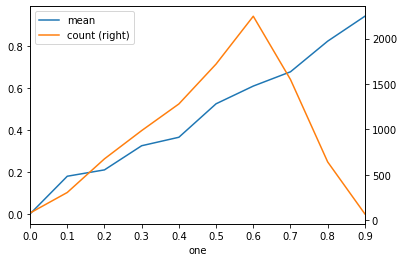

In [51]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [52]:
df_res_grouped

,mean,count
one,,
0.0,0.000000,80
0.1,0.179739,306
0.2,0.210059,676
0.3,0.325228,987
0.4,0.365625,1280
0.5,0.525305,1719
0.6,0.609800,2245
0.7,0.677857,1549
0.8,0.823988,642


### Prediction

#### Categorical

In [53]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target']
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)

#### Prediction for couple of papers

In [90]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes_merged,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fOPEN_fHIGH_chng', 'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE',
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 'pred_prob']
                                      ].tail(15)
    
        if one_res.shape == (15, 16):
            qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [91]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

In [92]:
total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
p5.start()


pbar = tqdm(total = total)

while qtransformed.qsize() != full_size:
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()


  7%|▋         | 25/347 [00:09<02:16,  2.36it/s]/home/showletter/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)

 52%|█████▏    | 182/347 [01:07<01:08,  2.40it/s]


 97%|█████████▋| 338/347 [02:09<00:03,  2.61it/s]


In [93]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)


100%|██████████| 347/347 [00:00<00:00, 801.88it/s]


In [94]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
p5.terminate()

In [101]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [103]:
res.loc[res.DTYYYYMMDD == '2020-04-16'].sort_values('pred_prob', ascending=False)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fOPEN_fHIGH_chng,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,pred_prob
3180,2020-04-16,KOMPUTRON,1.590,1.440,1.990,1.980,31.313131,1.980,1.950,2.600,2.55,28.787879,0.000000,30.653266,35.416667,0.838936
5257,2020-04-16,GROCLIN,1.215,1.200,1.400,1.340,5.970149,1.340,1.340,1.420,1.36,1.492537,0.000000,1.428571,11.666667,0.799555
3095,2020-04-16,RAINBOW,15.000,12.500,15.550,13.400,0.699301,14.300,13.600,14.400,13.90,-2.797203,6.716418,-7.395498,8.800000,0.791263
3737,2020-04-16,AMREST,28.600,26.250,28.950,26.250,0.000000,27.000,25.000,27.000,25.50,-5.555556,2.857143,-6.735751,-4.761905,0.789438
2041,2020-04-16,BIOMEDLUB,3.390,3.140,3.720,3.380,4.093567,3.420,3.080,3.560,3.22,-5.847953,1.183432,-4.301075,-1.910828,0.787086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5666,2020-04-16,RUBICON,0.505,0.505,0.505,0.505,0.000000,0.505,0.462,0.505,0.50,-0.990099,0.000000,0.000000,-8.514851,0.130573
3931,2020-04-16,DGA,4.460,4.400,4.480,4.400,0.000000,4.580,4.580,4.580,4.58,0.000000,4.090909,2.232143,4.090909,0.127789
4625,2020-04-16,SUWARY,11.800,11.800,11.800,11.800,0.000000,11.800,11.800,11.800,11.80,0.000000,0.000000,0.000000,0.000000,0.115376
5294,2020-04-16,ENAP,1.340,1.300,1.340,1.340,0.000000,1.340,1.320,1.340,1.34,0.000000,0.000000,0.000000,1.538462,0.101136


In [88]:
# for p in tqdm(list(skaner_df_see.ticker.values) + watch):

#     df = prepare_data(p)
#     df = transform_one_paper_ch(df)

#     df = df.merge(df_indexes_merged,
#                   left_index=True,
#                   right_index=True,
#                   how='left')

#     df.loc[:, 'pred_class'] = model.predict(df[train_cols])
#     df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

#     df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
#     df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
#     df.loc[:, 'target_gains'] = (df.loc[:, 'fut_CLOSE'] * 100 /
#                                  df.loc[:, 'fut_OPEN']) - 100
#     df.loc[:, 'target_OPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
#                                      df.loc[:, 'CLOSE']) - 100
#     df.loc[:, 'target_HIGH_chng'] = df.loc[:, 'chng_HIGH'].shift(-1).copy()
#     df.loc[:, 'target_CLOSE_chng'] = df.loc[:, 'chng_CLOSE'].shift(-1).copy()

#     one_res = df.reset_index().loc[:, [
#         'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 'target',
#         'pred_class', 'target_OPEN_chng', 'target_HIGH_chng',
#         'target_CLOSE_chng', 'target_gains', 'pred_prob'
#     ]].tail(15)
#     res = pd.concat([res, one_res])

100%|██████████| 262/262 [03:45<00:00,  1.16it/s]


In [89]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

target_OPEN_chng    -0.091508
target_HIGH_chng     0.768197
target_CLOSE_chng    0.876100
target_gains         1.012478
dtype: float64

In [90]:
res_see.loc[:,'pred_prob_rounded'] = res_see.pred_prob.round(1)

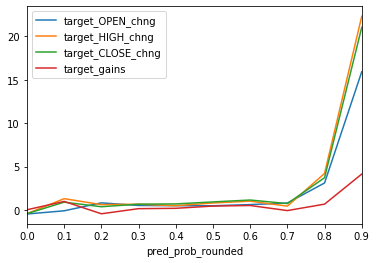

In [91]:
res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']].plot()

In [92]:
res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains
pred_prob_rounded,,,,
0.0,-0.446972,-0.407312,-0.407612,0.039885
0.1,-0.076972,1.319469,0.919571,1.003529
0.2,0.838205,0.633869,0.390130,-0.419619
0.3,0.538278,0.681568,0.688898,0.167654
0.4,0.512742,0.512726,0.715148,0.210677
0.5,0.502619,0.822701,0.945658,0.466910
0.6,0.637796,1.035346,1.164796,0.533442
0.7,0.814900,0.457629,0.753751,-0.051574
0.8,3.126858,4.223931,3.732391,0.688425


In [133]:
res_see_agg = res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

In [135]:
res_see.loc[(res_see.pred_prob > 0) 
            & (res_see.loc[:,'DTYYYYMMDD'] == '2020-04-15')].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains,pred_prob,pred_prob_rounded
841,2020-04-15,TBULL,14.1000,13.700,16.500,15.9000,1.0,1.0,0.628931,0.000000,2.830189,2.187500,0.861958,0.9
3179,2020-04-15,KOMPUTRON,1.2950,1.285,1.520,1.5100,1.0,1.0,5.298013,30.921053,31.125828,24.528302,0.823620,0.8
1057,2020-04-15,ENTER,25.0000,23.200,27.000,24.8000,0.0,1.0,4.032258,-4.444444,-4.032258,-7.751938,0.822492,0.8
3094,2020-04-15,RAINBOW,15.2000,14.000,16.400,14.9000,1.0,1.0,0.671141,-5.182927,-10.067114,-10.666667,0.820843,0.8
2040,2020-04-15,BIOMEDLUB,2.5800,2.410,3.800,3.8000,1.0,1.0,-10.789474,-2.105263,-11.052632,-0.294985,0.807443,0.8
5465,2020-04-15,TIM,9.5200,9.500,10.350,9.7200,1.0,1.0,0.000000,-0.483092,4.423868,4.423868,0.773835,0.8
1707,2020-04-15,UNIMOT,21.6000,20.700,22.600,22.0000,1.0,1.0,0.000000,2.212389,4.545455,4.545455,0.765069,0.8
3736,2020-04-15,AMREST,30.0000,26.100,31.250,28.7000,1.0,1.0,-0.348432,-7.360000,-8.536585,-8.216783,0.764013,0.8
3026,2020-04-15,ASBIS,3.4000,3.170,3.480,3.1700,1.0,1.0,0.946372,-4.310345,2.208202,1.250000,0.763845,0.8
6371,2020-04-15,MOSTALZAB,0.6580,0.600,0.674,0.6120,1.0,1.0,0.980392,-4.154303,3.267974,2.265372,0.761035,0.8


In [136]:
res_see.loc[(res_see.TICKER.apply(lambda x: True if x in watch else False) & (res_see.loc[:,'DTYYYYMMDD'] == '2020-04-15')),:]

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains,pred_prob,pred_prob_rounded
2040,2020-04-15,BIOMEDLUB,2.58,2.410,3.800,3.800,1.0,1.0,-10.789474,-2.105263,-11.052632,-0.294985,0.807443,0.8
3736,2020-04-15,AMREST,30.00,26.100,31.250,28.700,1.0,1.0,-0.348432,-7.360000,-8.536585,-8.216783,0.764013,0.8
2187,2020-04-15,JSW,15.00,13.610,15.185,13.810,0.0,1.0,0.289645,-8.495226,-1.375815,-1.660650,0.753465,0.8
1681,2020-04-15,SUNEX,9.90,9.000,9.980,9.280,1.0,1.0,-0.862069,-4.208417,2.801724,3.695652,0.746404,0.7
5694,2020-04-15,KGHM,76.00,69.520,76.000,70.260,0.0,1.0,1.053231,-5.973684,0.512383,-0.535211,0.727823,0.7
674,2020-04-15,PLAY,33.60,31.700,33.680,31.960,0.0,1.0,1.063830,-4.097387,-1.063830,-2.105263,0.719534,0.7
2478,2020-04-15,PZU,30.99,29.000,31.280,29.020,1.0,1.0,1.585114,-3.612532,3.893866,2.272727,0.719428,0.7
2599,2020-04-15,ARCTIC,4.19,3.800,4.210,3.990,1.0,1.0,1.754386,-1.900238,3.508772,1.724138,0.710754,0.7
3935,2020-04-15,INTERCARS,194.00,178.500,194.000,182.500,1.0,1.0,0.273973,-3.092784,3.013699,2.732240,0.702445,0.7
3068,2020-04-15,WIELTON,4.00,3.800,4.090,3.875,1.0,1.0,-1.032258,-2.444988,0.129032,1.173403,0.699814,0.7


In [261]:
res_std = res_see.groupby('DTYYYYMMDD')\
.mean()[['target_OPEN_chng', 'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']]

In [262]:
res_std = (res_std - res_std.mean()) / res_std.std()

In [265]:
res_std.corr()

,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,pred_prob
target_OPEN_chng,1.000000,0.747667,0.798805,0.259180
target_HIGH_chng,0.747667,1.000000,0.614235,0.644721
target_CLOSE_chng,0.798805,0.614235,1.000000,0.116755
pred_prob,0.259180,0.644721,0.116755,1.000000


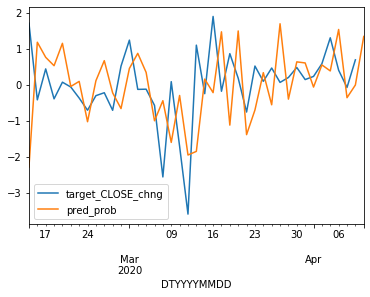

In [264]:
res_std[['target_CLOSE_chng', 'pred_prob']].plot()

In [335]:
df = df_merged.copy()

In [336]:
df.loc[:,'pred_class'] = model.predict(df[train_cols])
df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]

df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

In [340]:
res = df.reset_index()

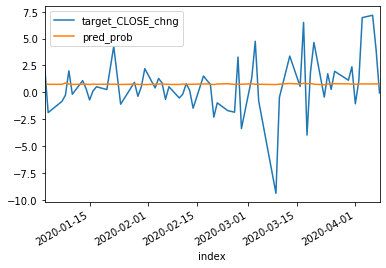

In [354]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.7), :].groupby(['index']).mean()[['target_CLOSE_chng', 'pred_prob']].plot()

In [360]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.8), :].groupby(['index']).mean()[
    ['target_HIGH_chng','target_CLOSE_chng', 'pred_prob']].median()

target_HIGH_chng     0.202429
target_CLOSE_chng    0.887612
pred_prob            0.833990
dtype: float64

In [355]:
res.sort_values('pred_prob', ascending=False).head(100)

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
199145,2011-08-11,PGE,17.85,19.250,17.6500,19.250,6.587300e+06,19.150,-6.788512,17.2400,...,1.0,2.857047,5.404341,-0.952958,1.0,0.967548,949.240,4831.116883,-6.512986,9.040890
541326,2020-03-19,WIG20LEV,228.15,248.410,221.7200,248.410,9.736780e+05,234.310,-2.628996,218.3100,...,1.0,1.330692,7.141789,-5.605968,1.0,0.960654,16.400,-93.398011,-4.576659,1.863354
541325,2020-03-19,PGE,3.65,4.036,3.6200,4.036,7.531181e+06,3.520,3.693182,3.3500,...,1.0,1.330692,7.141789,-5.605968,1.0,0.957879,228.150,5552.874133,0.327141,9.721731
199146,2011-08-11,WIG20LEV,949.24,1014.680,863.6800,1014.680,1.683095e+06,1071.960,-11.448188,878.6300,...,1.0,2.857047,5.404341,-0.952958,1.0,0.955207,84.500,-91.672251,-2.526316,4.360465
541313,2020-03-19,CCC,26.00,29.780,25.4000,29.600,2.128518e+06,26.840,-3.129657,24.3000,...,1.0,1.330692,7.141789,-5.605968,1.0,0.954583,3.000,-89.864865,-3.225806,-3.333333
540604,2020-03-13,LOTOS,42.04,45.900,39.8200,44.990,8.754780e+05,40.500,3.802469,39.0000,...,0.0,3.955261,13.908829,-6.080832,1.0,0.954446,1.870,-95.843521,-2.777778,-2.551020
202290,2011-09-15,CDPROJEKT,3.72,3.950,3.7200,3.950,8.404720e+05,3.650,1.917808,3.6200,...,1.0,1.349585,3.271462,-0.332003,1.0,0.952014,2.520,-36.202532,2.325581,4.761905
540955,2020-03-17,CIGAMES,0.41,0.436,0.4000,0.436,2.820567e+06,0.374,9.625668,0.3370,...,1.0,3.179108,13.518576,-3.209159,1.0,0.950566,10.000,2193.577982,-11.297071,0.200401
541403,2020-03-19,WIG30,1631.13,1712.070,1617.3100,1712.070,1.033160e+06,1635.080,-0.241578,1598.5800,...,1.0,1.330692,7.141789,-5.605968,1.0,0.949328,2977.070,73.887166,3.295832,5.038784
540924,2020-03-17,MABION,25.00,31.000,25.0000,31.000,9.760700e+04,20.000,25.000000,18.5000,...,1.0,3.179108,13.518576,-3.209159,1.0,0.947911,4.960,-84.000000,3.488372,6.024096


In [363]:
res.loc[res.pred_prob > 0.7].mean()

OPEN                    694.408521
HIGH                    706.094534
LOW                     691.763361
CLOSE                   705.061505
VOL                  479465.474154
                         ...      
pred_prob                 0.756463
fut_OPEN                361.378365
target_OPEN_chng       3284.682078
target_HIGH_chng          0.329685
target_CLOSE_chng         0.637524
Length: 276, dtype: float64

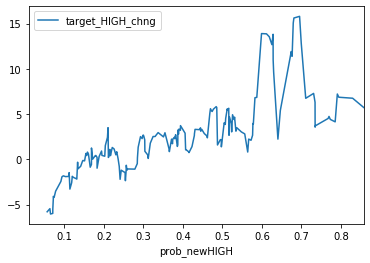

In [162]:
res.loc[:,['target_HIGH_chng', 'prob_newHIGH']]\
.sort_values('prob_newHIGH').set_index('prob_newHIGH').rolling(7).mean().plot()

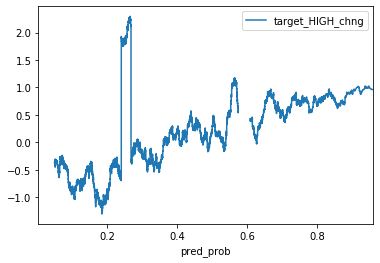

In [375]:
res.loc[res.loc[:,'index'] > '2020-01-01',['target_HIGH_chng', 'pred_prob']]\
.sort_values('pred_prob').set_index('pred_prob').rolling(500).mean().plot()

In [378]:
res.loc[res.loc[:,'index'] > '2020-04-07',:]

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
543985,2020-04-08,EFEKT,3.16,3.38,2.86,3.24,21180.0,2.58,22.480620,2.54,...,0.0,1.66631,5.106485,-1.166522,0.0,0.403466,25.70,693.209877,-9.507042,-7.692308
543986,2020-04-08,MABION,25.70,25.70,23.40,24.00,75002.0,28.40,-9.507042,25.65,...,0.0,1.66631,5.106485,-1.166522,0.0,0.242316,2.35,-90.208333,-1.673640,-10.638298
543987,2020-04-08,ELBUDOWA,2.35,2.35,1.91,2.10,129473.0,2.35,0.000000,2.18,...,0.0,1.66631,5.106485,-1.166522,0.0,0.113428,33.50,1495.238095,-10.053476,0.240964
543988,2020-04-08,CCC,33.50,33.64,31.50,33.28,521253.0,35.40,-5.367232,33.20,...,1.0,1.66631,5.106485,-1.166522,1.0,0.599440,2.94,-91.165865,-2.000000,-5.172414
543989,2020-04-08,SOLAR,2.94,2.94,2.65,2.75,10255.0,2.59,13.513514,2.48,...,0.0,1.66631,5.106485,-1.166522,0.0,0.181260,10.20,270.909091,-7.488987,-3.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544174,2020-04-08,EVEREST,7.20,7.20,7.00,7.20,1030.0,7.50,-4.000000,7.00,...,0.0,1.66631,5.106485,-1.166522,0.0,0.498369,8.00,11.111111,-0.934579,22.401848
544175,2020-04-08,PHARMENA,8.00,10.60,7.28,10.60,20106.0,10.50,-23.809524,8.52,...,1.0,1.66631,5.106485,-1.166522,1.0,0.701910,3.13,-70.471698,-24.074074,0.000000
544176,2020-04-08,BIOMEDLUB,3.13,4.10,2.64,3.40,9752784.0,5.10,-38.627451,3.33,...,1.0,1.66631,5.106485,-1.166522,1.0,0.529845,3.30,-2.941176,-13.157895,-5.120482
544177,2020-04-08,HARPER,3.30,3.30,2.97,3.15,164611.0,3.70,-10.810811,3.21,...,0.0,1.66631,5.106485,-1.166522,0.0,0.337076,0.27,-91.428571,-3.571429,-3.571429


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


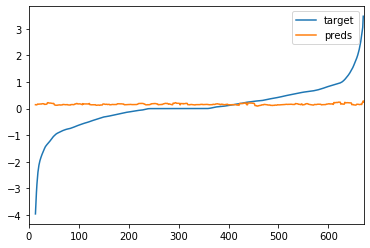

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

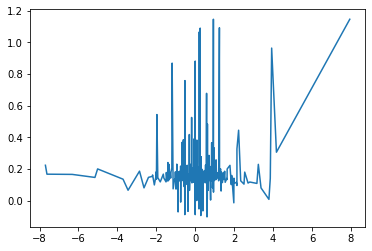

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

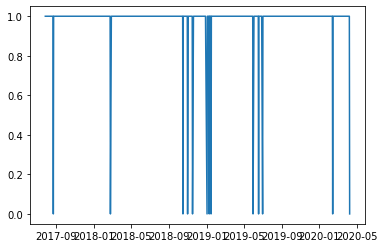

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Foreign indexes

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
